Dataset link: https://data.mendeley.com/datasets/tywbtsjrjv/1


# Deep learning model for crop diseases classification.

## First import and unzip dataset


In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Loading library

In [10]:
import matplotlib.pyplot as plt
from matplotlib import cm
from PIL import Image
import os
import numpy as np
from skimage import io
from keras.preprocessing.image import ImageDataGenerator
from mpl_toolkits.axes_grid1 import ImageGrid
import math
import shutil
%matplotlib inline

## Split the dataset into train, validation and test ds

In [ ]:
import os
import shutil
import random

# Set the paths
input_folder = '/content/drive/MyDrive/APU_DL_ASSG/Plant_leaf_diseases_dataset_grapes_only'
output_folder = '/content/drive/MyDrive/APU_DL_ASSG/plant_village_grapes_split'

# Create output folders for train, validation, and test sets
train_folder = os.path.join(output_folder, 'train')
val_folder = os.path.join(output_folder, 'validation')
test_folder = os.path.join(output_folder, 'test')

os.makedirs(train_folder, exist_ok=True)
os.makedirs(val_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)

# Set the split ratios
train_ratio = 0.8
val_ratio = 0.10
test_ratio = 0.10

# Iterate over subfolders
for class_folder in os.listdir(input_folder):
    class_path = os.path.join(input_folder, class_folder)

    # Create subdirectories in train, validation, and test folders
    os.makedirs(os.path.join(train_folder, class_folder), exist_ok=True)
    os.makedirs(os.path.join(val_folder, class_folder), exist_ok=True)
    os.makedirs(os.path.join(test_folder, class_folder), exist_ok=True)

    # Get the list of images in the current class folder
    images = os.listdir(class_path)

    # Shuffle the list of images
    random.shuffle(images)

    # Calculate the number of images for each split
    num_train = int(train_ratio * len(images))
    num_val = int(val_ratio * len(images))

    # Split the images into train, validation, and test sets
    train_images = images[:num_train]
    val_images = images[num_train:num_train+num_val]
    test_images = images[num_train+num_val:]

    # Copy images to the respective folders
    for img_name in train_images:
        src_path = os.path.join(class_path, img_name)
        dest_path = os.path.join(train_folder, class_folder, img_name)
        shutil.copy(src_path, dest_path)

    for img_name in val_images:
        src_path = os.path.join(class_path, img_name)
        dest_path = os.path.join(val_folder, class_folder, img_name)
        shutil.copy(src_path, dest_path)

    for img_name in test_images:
        src_path = os.path.join(class_path, img_name)
        dest_path = os.path.join(test_folder, class_folder, img_name)
        shutil.copy(src_path, dest_path)

print('Dataset split into train, validation, and test datasets')


## Setting up directories and Initial Data Analysis

In [11]:
base_dir = '/content/drive/MyDrive/APU_DL_ASSG/plant_village_grapes_split'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

In [12]:
import os
import pandas as pd

def count_images_in_folder(base_dir, datasets=('train', 'validation', 'test')):
    data = []
    # Iterate through all the subfolders in the base directory
    for dataset in datasets:
        dataset_path = os.path.join(base_dir, dataset)
        print(f"\nFolder: {dataset}")

        # Iterate through all subfolders in the split directory
        for subfolder in os.listdir(dataset_path):
            subfolder_path = os.path.join(dataset_path, subfolder)

            # Check if it's a directory and not-unwanted subfolder
            if os.path.isdir(subfolder_path) and subfolder not in ['train', 'validation', 'test']:
                # Count the number of images in the class subfolder
                image_count=sum([1 for file in os.listdir(subfolder_path) if file.lower().endswith(('.png', '.jpg', '.jpeg'))])
                data.append({'Dataset': dataset, 'Subfolder': subfolder, 'Image Count': image_count})
                # Print information
                print(f'Subfolder: {subfolder}, Number of images: {image_count}')

    dataset_image_count=pd.DataFrame(data)
    return dataset_image_count

In [13]:
count_images_in_folder(base_dir)


Folder: train
Subfolder: Grape___Black_rot, Number of images: 944
Subfolder: Grape___Esca_(Black_Measles), Number of images: 1106
Subfolder: Grape___healthy, Number of images: 338
Subfolder: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Number of images: 860

Folder: validation
Subfolder: Grape___Black_rot, Number of images: 118
Subfolder: Grape___Esca_(Black_Measles), Number of images: 138
Subfolder: Grape___healthy, Number of images: 42
Subfolder: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Number of images: 107

Folder: test
Subfolder: Grape___Black_rot, Number of images: 118
Subfolder: Grape___Esca_(Black_Measles), Number of images: 139
Subfolder: Grape___healthy, Number of images: 43
Subfolder: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Number of images: 109


,Dataset,Subfolder,Image Count
0,train,Grape___Black_rot,944
1,train,Grape___Esca_(Black_Measles),1106
2,train,Grape___healthy,338
3,train,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),860
4,validation,Grape___Black_rot,118
5,validation,Grape___Esca_(Black_Measles),138
6,validation,Grape___healthy,42
7,validation,Grape___Leaf_blight_(Isariopsis_Leaf_Spot),107
8,test,Grape___Black_rot,118
9,test,Grape___Esca_(Black_Measles),139


In [14]:
# count the total number of images in each of the train, test and val datasets.

def total_images(base_dir, datasets=('train', 'validation', 'test')):
    count=[]

    for ds in datasets:
        ds_path=os.path.join(base_dir, ds)
        total_count = 0
        for class_folder in os.listdir(ds_path):
            class_path = os.path.join(ds_path, class_folder)
            image_count_class = 0
            for image in os.listdir(class_path):
              if image.lower().endswith(('.jpg','.jpeg')):
                image_count_class += 1
            total_count += image_count_class

        # Append total count for the split
        count.append({'Dataset': ds, 'Total number of images': total_count})

    dataset_image_count= pd.DataFrame(count)
    return dataset_image_count

base_directory = '/content/drive/MyDrive/APU_DL_ASSG/plant_village_grapes_split'
total_images(base_directory)


,Dataset,Total number of images
0,train,3248
1,validation,405
2,test,409


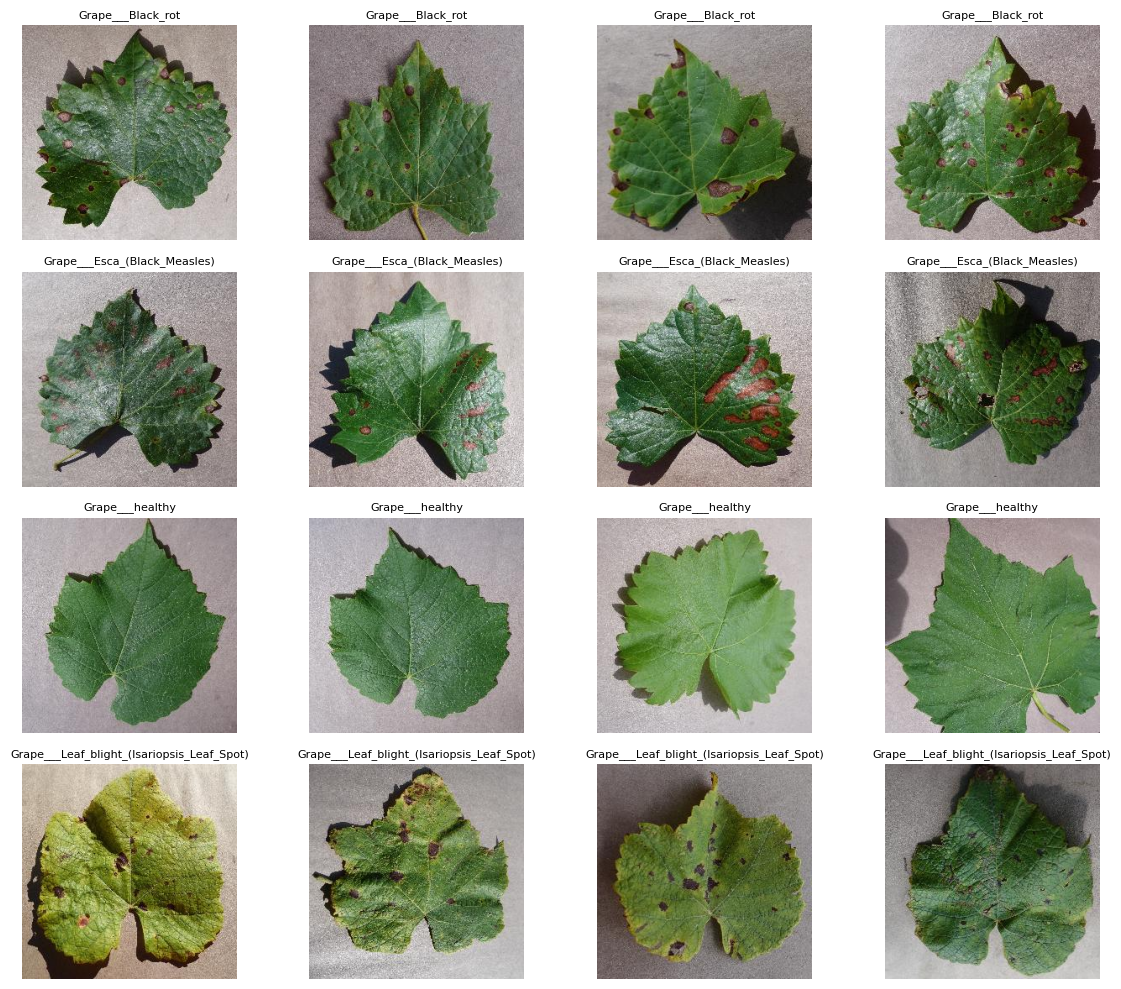

In [15]:
import os
import matplotlib.pyplot as plt
from PIL import Image

dataset_path = train_dir
# function to display images from each class in the train ds in a 4x4 grid
def display_images_in_grid(dataset_path, num_images_per_class=4):
    class_names=[class_name for class_name in os.listdir(dataset_path)]
    rows=len(class_names)
    cols=num_images_per_class

    fig,axes=plt.subplots(rows,cols,figsize=(12, 10))

    for x,class_name in enumerate(class_names):
        class_path=os.path.join(dataset_path,class_name)
        images_in_class=os.listdir(class_path)[:num_images_per_class]

        for y,image_name in enumerate(images_in_class):
            image_path=os.path.join(class_path,image_name)
            img=Image.open(image_path)

            axes[x,y].imshow(img)
            axes[x,y].set_title(class_name, fontsize=8)
            axes[x,y].axis(False)

    plt.tight_layout()
    plt.show()


display_images_in_grid(dataset_path)


## Aug and preprocessing

In [16]:
# Normalization - Rescale the images by 1./255 in validation and testing datasets
val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
batch_size = 20

# create a dictionary about argument for data augmentation in training ds.
train_datagen_args = dict(rotation_range=90, # random image rotation, this makes rotated image w/ random angle ranging up to 90 degrees each time
                    width_shift_range=0.2, # randomly shifts the width and height of the image by a
                                           # 20% of the total width or height, respectively.
                    height_shift_range=0.2,
                    zoom_range=0.2, # randomly zooms into or out of each of the image by 20%
                    horizontal_flip=True,
                    vertical_flip=True, # randomly flips the image horizontally and vertically.
                    brightness_range=[0.5,1.5], #  adjust the brightness of the image by a random % within the range of 0.5 and 1.5.
                                                #  this is to stimulate the images under different lighting conditions.
                    rescale=1./255) # normalise the images by rescaling the images by 1./255

train_datagen = ImageDataGenerator(**train_datagen_args)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(224, 224),
        batch_size= batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_directory(
        validation_dir,
        target_size=(224, 224),
        batch_size= batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(224, 224),
        batch_size= batch_size,
        class_mode='categorical')

Found 3248 images belonging to 4 classes.
Found 405 images belonging to 4 classes.
Found 409 images belonging to 4 classes.


In [17]:
print("number of images", train_generator.samples)
print("number of class", len(train_generator.class_indices))
print("number of images in the classes", train_generator.samples / len(train_generator.class_indices))

number of images 3248
number of class 4
number of images in the classes 812.0


In [18]:
print(train_generator.class_indices)

{'Grape___Black_rot': 0, 'Grape___Esca_(Black_Measles)': 1, 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)': 2, 'Grape___healthy': 3}


## Functions




In [19]:
# Function to plot the accuracy, loss of the model
import matplotlib.pyplot as plt
def model_evaluation(history):
  accuracy = history['accuracy']
  val_acc = history['val_accuracy']
  loss = history['loss']
  val_loss = history['val_loss']

  epochs = range(len(val_acc))

  plt.plot(epochs, accuracy, 'g', label ='training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.figure()
  plt.plot(epochs, loss, 'g', label='training loss')
  plt.plot(epochs, val_loss, 'b', label='validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.show()

In [20]:
# Function to conduct model performance

def model_performance(model_name, dataset = test_generator):
  from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
  # generate predictions
  y_pred = model_name.predict(dataset)
  # convert predictions to class labels
  y_pred_labels = np.argmax(y_pred, axis=1)
  # obtain true labels
  y_true = dataset.classes
  # generate classification report and accuracy
  print(classification_report(y_true, y_pred_labels))

In [21]:
# function to save the models and history of models
def save_model_info(model_name, history_name):
    # Save the model
    model_name.save('/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/', f'{model_name}.h5')

    # Save the history
    import pickle
    path_to_save = '/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/' + f'{history_name}.pkl'
    with open(path_to_save, 'wb') as file:
        pickle.dump(history_name.history, file)


# function to load the model and history of model
def load_model(model_name,history_name):
  from keras.models import load_model
  import pickle
  # load the model
  model = load_model('/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/' + model_name + '.h5')

  # load history of model
  history_path='/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/'+ history_name + '.pkl'
  with open(history_path,'rb') as file:
    history = pickle.load(file)
  return model, history

# Model Building

## Transfer Learning VGG16 (All layers frozen, SGD optimizer) - Model 1 (baseline model)

In [ ]:
import keras

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import  plot_model
from keras import optimizers
import keras.models as models
import tensorflow as tf
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
# The following code removes the top prediction layers of VGG16 trained on imagenet.
# Original input dmensions are retained as 224x224x3.
import keras
vgg16 = VGG16(include_top=False,
              weights='imagenet',
              input_shape=(224,224,3),
              pooling=None)

for layer in vgg16.layers:
    layer.trainable = False # freeze all layers in covolutional layers of VGG16

# initiate the sequential model and add the VGG16 model
model3 = Sequential()
model3.add(vgg16)
# Add the custom layers atop the VGG16 model:
model3.add(Flatten(name='flattened'))
model3.add(Dropout(0.5, name='dropout1'))
model3.add(Dense(512, activation='relu'))
model3.add(Dropout(0.2, name='dropout2'))
model3.add(Dense(4, activation='softmax', name='predictions')) # 4 classess, so 4 neurons

model3.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate= 0.001),
              metrics=['accuracy'])

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 predictions (Dense)         (None, 4)                 2052      
                                                                 
Total params: 27562308 (105.14 MB)
Trainable params: 128

In [ ]:
history3 = model3.fit(train_generator,
                    steps_per_epoch = 150,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = 20)

Epoch 1/30
150/150 [==============================] - 702s 5s/step - loss: 1.2834 - accuracy: 0.4280 - val_loss: 0.8620 - val_accuracy: 0.6775
Epoch 2/30
150/150 [==============================] - 95s 637ms/step - loss: 0.9940 - accuracy: 0.5740 - val_loss: 0.5885 - val_accuracy: 0.8750
Epoch 3/30
150/150 [==============================] - 61s 404ms/step - loss: 0.8457 - accuracy: 0.6446 - val_loss: 0.4869 - val_accuracy: 0.8850
Epoch 4/30
150/150 [==============================] - 65s 435ms/step - loss: 0.7624 - accuracy: 0.6817 - val_loss: 0.4371 - val_accuracy: 0.9025
Epoch 5/30
150/150 [==============================] - 60s 400ms/step - loss: 0.6934 - accuracy: 0.7065 - val_loss: 0.4069 - val_accuracy: 0.8450
Epoch 6/30
150/150 [==============================] - 59s 394ms/step - loss: 0.6610 - accuracy: 0.7239 - val_loss: 0.3705 - val_accuracy: 0.8575
Epoch 7/30
150/150 [==============================] - 60s 400ms/step - loss: 0.6056 - accuracy: 0.7614 - val_loss: 0.3816 - val_accu

In [ ]:
model3.save('/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/model3.h5')
import pickle
path_to_save = '/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/history3.pk1'
with open(path_to_save,'wb') as file:
  pickle.dump(history3.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [43]:
# Load model and the history of model using load_model function
model3, history3 = load_model('model3','history3')

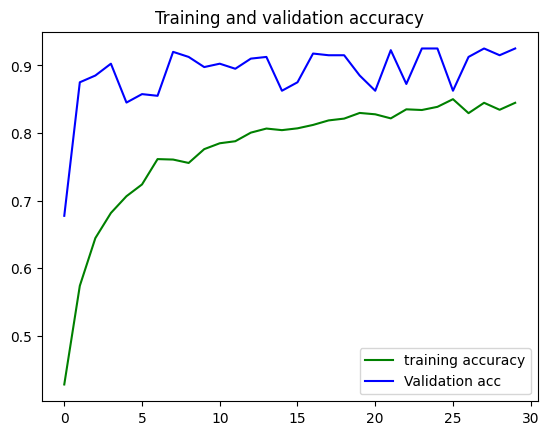

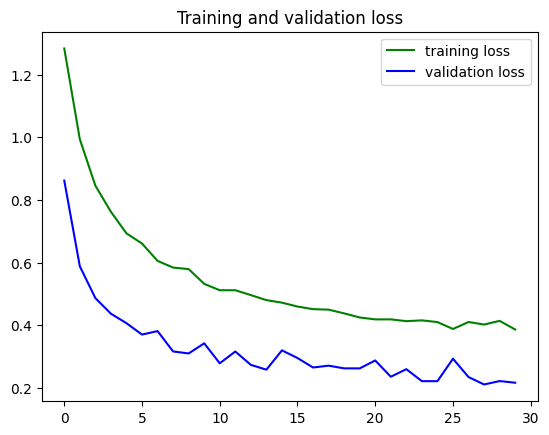

In [44]:
# Plot the chart to visualise for training and validation accuracy and loss of the model.
model_evaluation(history3)

In [47]:
# Evaluate the model performance on the test dataset
test_loss, test_accuracy = model3.evaluate(test_generator)

# print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model performance based on other metrics such as recall, precision, F1 score
model_performance(model3)

21/21 [==============================] - 3s 115ms/step - loss: 0.2224 - accuracy: 0.9046
Test Loss: 0.2223612666130066
Test Accuracy: 0.9046455025672913
21/21 [==============================] - 3s 114ms/step
              precision    recall  f1-score   support

           0       0.30      0.31      0.30       118
           1       0.33      0.32      0.32       139
           2       0.27      0.27      0.27       109
           3       0.22      0.23      0.23        43

    accuracy                           0.29       409
   macro avg       0.28      0.28      0.28       409
weighted avg       0.29      0.29      0.29       409



## Transfer Learning VGG16 (with layers in block 5 unfrozen and trainable, SGD optimizer) - Model 2

In [ ]:
# import useful library first
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import optimizers
import pandas as pd

In [ ]:
import tensorflow as tf
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
#definining the vgg model first
vgg_model = VGG16(include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3),
                  pooling=None)

In [ ]:
# set which layers to be frozen and unfrozen

vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
  if layer.name in ['block5_conv1']:
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

# This will alow the layers in block5 to be unfrozen.

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer objec...,input_1,False
1,<keras.src.layers.convolutional.conv2d.Conv2D ...,block1_conv1,False
2,<keras.src.layers.convolutional.conv2d.Conv2D ...,block1_conv2,False
3,<keras.src.layers.pooling.max_pooling2d.MaxPoo...,block1_pool,False
4,<keras.src.layers.convolutional.conv2d.Conv2D ...,block2_conv1,False
5,<keras.src.layers.convolutional.conv2d.Conv2D ...,block2_conv2,False
6,<keras.src.layers.pooling.max_pooling2d.MaxPoo...,block2_pool,False
7,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv1,False
8,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv2,False
9,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv3,False


In [ ]:
# Initialize the sequential model and add the VGG16 model to it
model2 = Sequential()
model2.add(vgg_model)

# Add the customised layes on top of the VGG16 pretrained model.
model2.add(Flatten(name = 'flattened'))
model2.add(Dropout(0.5, name = 'dropout1'))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.2, name='dropout2'))
model2.add(Dense(4, activation='softmax', name='predictions'))

model2.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])


In [ ]:
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flattened (Flatten)         (None, 25088)             0         
                                                                 
 dropout1 (Dropout)          (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout2 (Dropout)          (None, 512)               0         
                                                                 
 predictions (Dense)         (None, 4)                 2052      
                                                                 
Total params: 27562308 (105.14 MB)
Trainable params: 199

In [ ]:
history2 = model2.fit(train_generator,
                    steps_per_epoch = 150,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = 20)

Epoch 1/30
150/150 [==============================] - 61s 395ms/step - loss: 1.1714 - accuracy: 0.4869 - val_loss: 0.4926 - val_accuracy: 0.8475
Epoch 2/30
150/150 [==============================] - 59s 395ms/step - loss: 0.5967 - accuracy: 0.7614 - val_loss: 0.2949 - val_accuracy: 0.8900
Epoch 3/30
150/150 [==============================] - 60s 401ms/step - loss: 0.4238 - accuracy: 0.8384 - val_loss: 0.1855 - val_accuracy: 0.9300
Epoch 4/30
150/150 [==============================] - 59s 394ms/step - loss: 0.3094 - accuracy: 0.8800 - val_loss: 0.1901 - val_accuracy: 0.9350
Epoch 5/30
150/150 [==============================] - 60s 397ms/step - loss: 0.2741 - accuracy: 0.9043 - val_loss: 0.1284 - val_accuracy: 0.9625
Epoch 6/30
150/150 [==============================] - 61s 406ms/step - loss: 0.2345 - accuracy: 0.9120 - val_loss: 0.4876 - val_accuracy: 0.7825
Epoch 7/30
150/150 [==============================] - 61s 404ms/step - loss: 0.2205 - accuracy: 0.9147 - val_loss: 0.1167 - val_ac

In [ ]:
model2.save('/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/model2.h5')
import pickle
path_to_save = '/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/history2.pkl'
with open(path_to_save,'wb') as file:
  pickle.dump(history2.history, file)

In [40]:
# Load model and model history
model2,history2 = load_model('model2','history2')

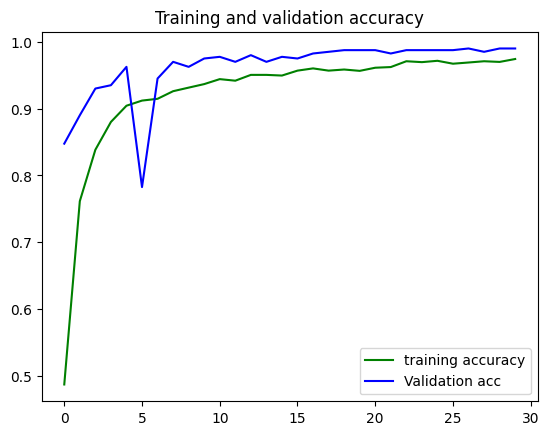

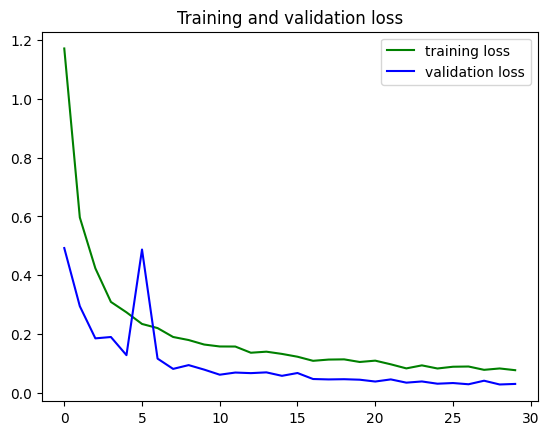

In [41]:
# Plot the chart to visualise for training and validation accuracy and loss of the model.
model_evaluation(history2)

In [42]:
# Evaluate the model performance on the test dataset
test_loss, test_accuracy = model2.evaluate(test_generator)

# print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model performance based on other metrics such as recall, precision, F1 score
model_performance(model2)

21/21 [==============================] - 2s 99ms/step - loss: 0.0249 - accuracy: 0.9878
Test Loss: 0.024900760501623154
Test Accuracy: 0.9877750873565674
21/21 [==============================] - 3s 121ms/step
              precision    recall  f1-score   support

           0       0.27      0.25      0.26       118
           1       0.32      0.33      0.33       139
           2       0.32      0.32      0.32       109
           3       0.12      0.12      0.12        43

    accuracy                           0.28       409
   macro avg       0.26      0.26      0.26       409
weighted avg       0.28      0.28      0.28       409



# Fine tuning

## Fine Tuned Model 1 - Layers in Block 5 trainable,learning rate for SGD optimizer changed to 0.01 from 0.001

In [ ]:
import keras

from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import  plot_model
from keras import optimizers
import keras.models as models
import tensorflow as tf
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [ ]:
#definining the vgg model first
vgg_model = VGG16(include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3),
                  pooling=None)
# set which layers to be frozen and unfrozen
vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
  if layer.name in ['block5_conv1']:
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
# This will alow the layers incblock5 to be unfrozen.

# Initialize the sequential model and add the VGG16 model to it
model5 = Sequential()
model5.add(vgg_model)

# Add the customised layes on top of the VGG16 pretrained model.
model5.add(Flatten(name = 'flattened'))
model5.add(Dropout(0.5, name = 'dropout1'))
model5.add(Dense(512, activation='relu'))
model5.add(Dropout(0.2, name='dropout2'))
model5.add(Dense(4, activation='softmax', name='predictions'))

model5.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.01), # default LR
              metrics=['accuracy'])

history5 = model5.fit(train_generator,
                    steps_per_epoch = 150,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = 20)

Epoch 1/30
150/150 [==============================] - 63s 408ms/step - loss: 1.1332 - accuracy: 0.5094 - val_loss: 0.4030 - val_accuracy: 0.8400
Epoch 2/30
150/150 [==============================] - 61s 408ms/step - loss: 0.4956 - accuracy: 0.8102 - val_loss: 0.1565 - val_accuracy: 0.9375
Epoch 3/30
150/150 [==============================] - 59s 391ms/step - loss: 0.3254 - accuracy: 0.8889 - val_loss: 0.1671 - val_accuracy: 0.9350
Epoch 4/30
150/150 [==============================] - 61s 404ms/step - loss: 0.1948 - accuracy: 0.9307 - val_loss: 0.0941 - val_accuracy: 0.9675
Epoch 5/30
150/150 [==============================] - 59s 394ms/step - loss: 0.1841 - accuracy: 0.9340 - val_loss: 0.0731 - val_accuracy: 0.9700
Epoch 6/30
150/150 [==============================] - 59s 395ms/step - loss: 0.1847 - accuracy: 0.9284 - val_loss: 0.3551 - val_accuracy: 0.9125
Epoch 7/30
150/150 [==============================] - 58s 387ms/step - loss: 0.1442 - accuracy: 0.9465 - val_loss: 0.0895 - val_ac

In [ ]:
model5.save('/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/model5.h5')
import pickle
path_to_save = '/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/history5.pkl'
with open(path_to_save,'wb') as file:
  pickle.dump(history5.history, file)

In [23]:
# Load model and the history of model using load_model function
model5, history5 = load_model('model5','history5')

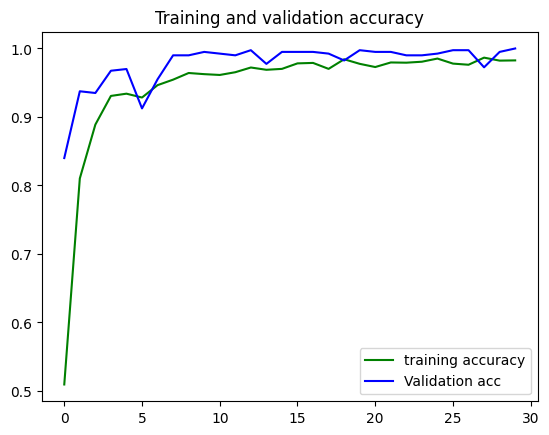

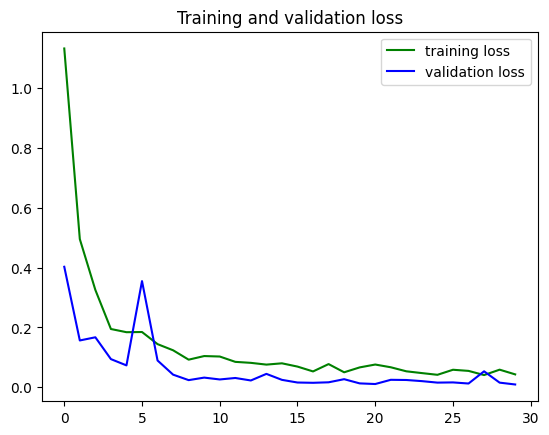

In [ ]:
# Plot the chart to visualise for training and validation accuracy and loss of the model.
model_evaluation(history5)

In [24]:
# Evaluate the model performance on the test dataset
test_loss, test_accuracy = model5.evaluate(test_generator)

# print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model performance based on other metrics such as recall, precision, F1 score
model_performance(model5)

21/21 [==============================] - 158s 8s/step - loss: 0.0135 - accuracy: 0.9976
Test Loss: 0.013548803515732288
Test Accuracy: 0.9975550174713135
21/21 [==============================] - 154s 7s/step
              precision    recall  f1-score   support

           0       0.28      0.28      0.28       118
           1       0.36      0.37      0.37       139
           2       0.26      0.26      0.26       109
           3       0.09      0.09      0.09        43

    accuracy                           0.28       409
   macro avg       0.25      0.25      0.25       409
weighted avg       0.28      0.28      0.28       409



## Fine Tuned Model 2 - Layers in Block 5 trainable, Dropout 2 layer changed to 0.5 from 0.2, learning rate for SGD optimizer changed to 0.01 from 0.001

In [21]:
import keras
from keras.applications.vgg16 import VGG16
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import  plot_model
from keras import optimizers
import keras.models as models
import tensorflow as tf
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [22]:
#definining the vgg model first
vgg_model = VGG16(include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3),
                  pooling=None)
# set which layers to be frozen and unfrozen
vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
  if layer.name in ['block5_conv1']:
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])
# This will alow the layers in block5 to be unfrozen.

# Initialize the sequential model and add the VGG16 model to it
model6 = Sequential()
model6.add(vgg_model)

# Add the customised layes on top of the VGG16 pretrained model.
model6.add(Flatten(name = 'flattened'))
model6.add(Dropout(0.5, name = 'dropout1'))
model6.add(Dense(512, activation='relu'))
model6.add(Dropout(0.5, name='dropout2'))
model6.add(Dense(4, activation='softmax', name='predictions'))

model6.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.01), # default LR
              metrics=['accuracy'])

history6 = model6.fit(train_generator,
                    steps_per_epoch = 150,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = 20)

Epoch 1/30
150/150 [==============================] - 324s 2s/step - loss: 1.0994 - accuracy: 0.5318 - val_loss: 0.5205 - val_accuracy: 0.8100
Epoch 2/30
150/150 [==============================] - 65s 431ms/step - loss: 0.4641 - accuracy: 0.8163 - val_loss: 0.2841 - val_accuracy: 0.8650
Epoch 3/30
150/150 [==============================] - 61s 409ms/step - loss: 0.3607 - accuracy: 0.8645 - val_loss: 0.1256 - val_accuracy: 0.9525
Epoch 4/30
150/150 [==============================] - 60s 399ms/step - loss: 0.2515 - accuracy: 0.9060 - val_loss: 0.0812 - val_accuracy: 0.9650
Epoch 5/30
150/150 [==============================] - 63s 422ms/step - loss: 0.1786 - accuracy: 0.9351 - val_loss: 0.0665 - val_accuracy: 0.9675
Epoch 6/30
150/150 [==============================] - 71s 472ms/step - loss: 0.3123 - accuracy: 0.8916 - val_loss: 0.3459 - val_accuracy: 0.8800
Epoch 7/30
150/150 [==============================] - 76s 504ms/step - loss: 0.2641 - accuracy: 0.9009 - val_loss: 0.1028 - val_accu

In [23]:
# Save the model and model history
model6.save('/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/model6.h5')
import pickle
path_to_save = '/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/history6.pkl'
with open(path_to_save,'wb') as file:
  pickle.dump(history6.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [32]:
# Load the model and model history
model6, history6 = load_model('model6','history6')

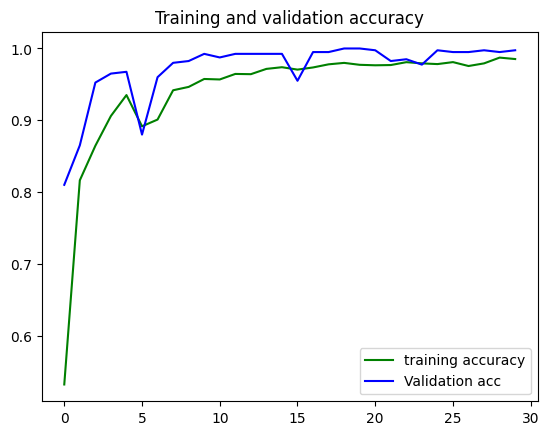

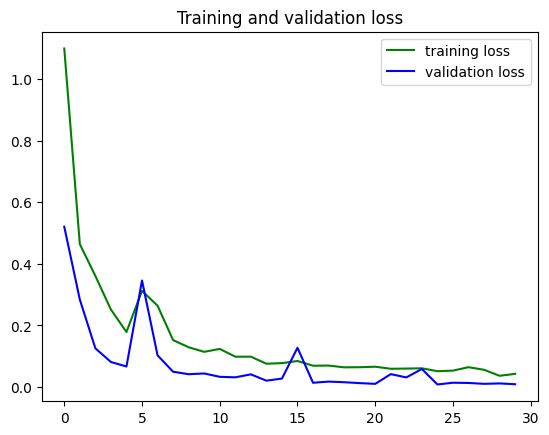

In [33]:
# To visualize the training and validation accuracy as well as the training and validation loss over epochs.
model_evaluation(history6)

In [34]:
# Evaluate the model performance on the test dataset
test_loss, test_accuracy = model6.evaluate(test_generator)

# print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model performance based on other metrics such as recall, precision, F1 score
model_performance(model6)

21/21 [==============================] - 2s 97ms/step - loss: 0.0088 - accuracy: 1.0000
Test Loss: 0.008841071277856827
Test Accuracy: 1.0
21/21 [==============================] - 2s 97ms/step
              precision    recall  f1-score   support

           0       0.26      0.26      0.26       118
           1       0.34      0.34      0.34       139
           2       0.33      0.33      0.33       109
           3       0.12      0.12      0.12        43

    accuracy                           0.29       409
   macro avg       0.26      0.26      0.26       409
weighted avg       0.29      0.29      0.29       409



## Fine Tuned Model 3 - Layers in Block 4 and 5 trainable, optmizer and learning rate remained at SGD and 0.001 respectively.

In [2]:
# import useful library first
import keras
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Dropout, Flatten
from keras.models import Sequential
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras import optimizers
import pandas as pd

import tensorflow as tf
keras.backend.clear_session()
np.random.seed(123)
tf.random.set_seed(123)

In [4]:
#definining the vgg model first
vgg_model = VGG16(include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3),
                  pooling=None)

58889256/58889256 [==============================] - 1s 0us/step


In [5]:
# set which layers to be frozen and unfrozen

vgg_model.trainable = True
set_trainable = False

for layer in vgg_model.layers:
  if layer.name in ['block4_conv1','block5_conv1']:
    set_trainable = True
  if set_trainable == True:
    layer.trainable = True
  else:
    layer.trainable = False

layers = [(layer, layer.name, layer.trainable) for layer in vgg_model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

# This will alow the layers in block5 to be unfrozen.

,Layer Type,Layer Name,Layer Trainable
0,<keras.src.engine.input_layer.InputLayer objec...,input_1,False
1,<keras.src.layers.convolutional.conv2d.Conv2D ...,block1_conv1,False
2,<keras.src.layers.convolutional.conv2d.Conv2D ...,block1_conv2,False
3,<keras.src.layers.pooling.max_pooling2d.MaxPoo...,block1_pool,False
4,<keras.src.layers.convolutional.conv2d.Conv2D ...,block2_conv1,False
5,<keras.src.layers.convolutional.conv2d.Conv2D ...,block2_conv2,False
6,<keras.src.layers.pooling.max_pooling2d.MaxPoo...,block2_pool,False
7,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv1,False
8,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv2,False
9,<keras.src.layers.convolutional.conv2d.Conv2D ...,block3_conv3,False


In [22]:
#definining the vgg model first
vgg_model = VGG16(include_top = False,
                  weights = 'imagenet',
                  input_shape = (224,224,3),
                  pooling=None)

# Initialize the sequential model and add the VGG16 model to it
model7 = Sequential()
model7.add(vgg_model)

# Add the customised layes on top of the VGG16 pretrained model.
model7.add(Flatten(name = 'flattened'))
model7.add(Dropout(0.5, name = 'dropout1'))
model7.add(Dense(512, activation='relu'))
model7.add(Dropout(0.2, name='dropout2'))
model7.add(Dense(4, activation='softmax', name='predictions'))

model7.compile(loss='categorical_crossentropy',
              optimizer=optimizers.SGD(learning_rate=0.001),
              metrics=['accuracy'])

history7 = model7.fit(train_generator,
                    steps_per_epoch = 150,
                    epochs = 30,
                    validation_data = validation_generator,
                    validation_steps = 20)

Epoch 1/30
150/150 [==============================] - 816s 5s/step - loss: 1.0616 - accuracy: 0.5462 - val_loss: 0.4089 - val_accuracy: 0.8300
Epoch 2/30
150/150 [==============================] - 99s 661ms/step - loss: 0.4049 - accuracy: 0.8440 - val_loss: 0.0562 - val_accuracy: 0.9850
Epoch 3/30
150/150 [==============================] - 74s 488ms/step - loss: 0.2009 - accuracy: 0.9317 - val_loss: 0.1593 - val_accuracy: 0.9275
Epoch 4/30
150/150 [==============================] - 71s 473ms/step - loss: 0.1576 - accuracy: 0.9505 - val_loss: 0.0292 - val_accuracy: 0.9900
Epoch 5/30
150/150 [==============================] - 72s 481ms/step - loss: 0.1681 - accuracy: 0.9528 - val_loss: 0.2439 - val_accuracy: 0.9175
Epoch 6/30
150/150 [==============================] - 73s 484ms/step - loss: 0.1143 - accuracy: 0.9669 - val_loss: 0.0276 - val_accuracy: 0.9900
Epoch 7/30
150/150 [==============================] - 71s 475ms/step - loss: 0.0807 - accuracy: 0.9736 - val_loss: 0.0104 - val_accu

In [23]:
# save model
model7.save('/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/model7.h5')
import pickle
path_to_save = '/content/drive/MyDrive/APU_DL_ASSG/DL_ASSG_WORKSPACE/models/history7.pkl'
with open(path_to_save,'wb') as file:
  pickle.dump(history7.history, file)

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [24]:
# load model
model7,history7 = load_model('model7','history7')

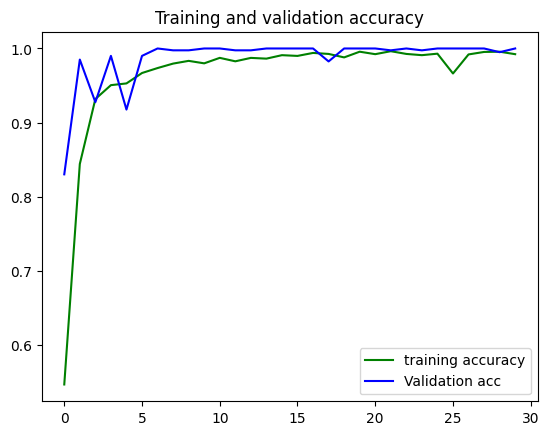

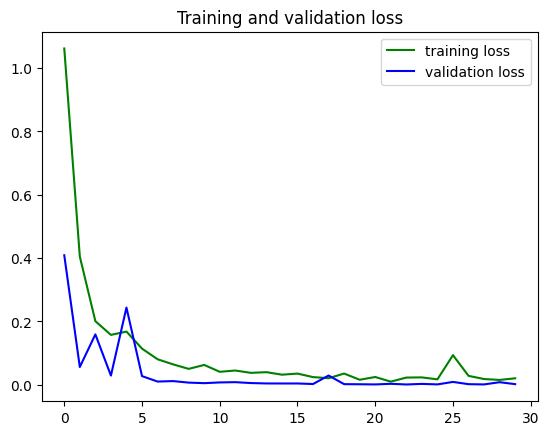

In [25]:
# show the chart of training and validation accuracy and loss

model_evaluation(history7)

In [27]:
# Evaluate the model performance on the test dataset
test_loss, test_accuracy = model7.evaluate(test_generator)

# print the test loss and accuracy
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

# Evaluate the model performance based on other metrics such as recall, precision, F1 score
model_performance(model7)

21/21 [==============================] - 118s 6s/step - loss: 0.0105 - accuracy: 0.9976
Test Loss: 0.010464176535606384
Test Accuracy: 0.9975550174713135
21/21 [==============================] - 2s 92ms/step
              precision    recall  f1-score   support

           0       0.27      0.27      0.27       118
           1       0.31      0.31      0.31       139
           2       0.27      0.27      0.27       109
           3       0.14      0.14      0.14        43

    accuracy                           0.27       409
   macro avg       0.25      0.25      0.25       409
weighted avg       0.27      0.27      0.27       409

